# Using FakeBERT Architecture for Sequence Classification

[Original FakeBERT Paper](https://link.springer.com/content/pdf/10.1007/s11042-020-10183-2.pdf)

FakeBERT Architecture:

![FakeBERT](fakebert.PNG "FakeBERT Architecture")

Summary:

Questions:
* Do we need to split train/test when we load the csv files? I think this should happen in DataLoader
** I would say yes we should have train/validate/test csv files so we can separate our concerns one time and the huggingface library has a useful way to grab data by type in separate CSVs - Megan
* Do we really need a main.py? This could probably be in the notebook
** I agree - Megan


TODO:
- (SKIP) Create config.xml files in config folder and load them into the notebook via the method used in assignments

- Save preprocessed code with the regex (cleaning out newspaper meta data and removing sequences below certain sizze) into data folder so it can be tokenized (test.csv, train.csv, validation.csv)

- (DONE) (for now, run again with preprocessed data files)Run tokenizer code ONCE and save to pickle (to spare the 10 minute runtime every time this notebook loads)

- (DONE) Pull BertModel out of this notebook and use the sources/models/FakeBert.py

- Look at adding the BERT embedding to the nn.Module with the gradients? (maybe why accuracy is not good right now, since it isn't in computation graph?)

- Create a new sources/models/BertLinear.py with a simple nn.Module to turn the embeddings into a linear layer

- Clean the commented out code


In [1]:
# Mount into drive

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# This is the location of the root directory (on github it would be cs7643-project)
# Yours might look different - Megan
root = '/content/drive/MyDrive/CS7643/Project'
root = '/content/drive/MyDrive/sankarc/cs7643-project'

In [6]:
# Detect PY file updates and reload
%load_ext autoreload
%autoreload 2

In [7]:
#%cd drive/MyDrive/Colab\ Notebooks/dl_project
import os
os.chdir(root)
%pwd

'/content/drive/MyDrive/sankarc/cs7643-project'

In [ ]:
%ls

data/       experiments/  proposal/     README.md  Tutorials
dataset.py  notebooks/    __pycache__/  source/    untitled


### Installations

In [8]:
!pip install transformers
!pip install datasets
!pip install adjustText

     |████████████████████████████████| 4.0 MB 28.9 MB/s 
     |████████████████████████████████| 596 kB 57.8 MB/s 
     |████████████████████████████████| 895 kB 56.4 MB/s 
     |████████████████████████████████| 77 kB 7.5 MB/s 
     |████████████████████████████████| 6.6 MB 54.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 325 kB 25.9 MB/s 
     |████████████████████████████████| 212 kB 65.7 MB/s 
     |████████████████████████████████| 1.1 MB 66.9 MB/s 
     |████████████████████████████████| 136 kB 77.6 MB/s 
     |████████████████████████████████| 127 kB 74.1 MB/s 
     |████████████████████████████████| 144 kB 71.8 MB/s 
     |████████████████████████████████| 271 kB 65.8 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urll

In [9]:
#!pip install -r 'requirements.txt'
!pip install -r 'notebooks/requirement.txt'

     |████████████████████████████████| 97 kB 7.9 MB/s 
     |████████████████████████████████| 157 kB 71.1 MB/s 
     |████████████████████████████████| 9.9 MB 60.0 MB/s 
     |████████████████████████████████| 929 kB 52.8 MB/s 
     |████████████████████████████████| 156 kB 72.0 MB/s 
     |████████████████████████████████| 97 kB 8.7 MB/s 
     |████████████████████████████████| 3.6 MB 61.7 MB/s 
ERROR: Could not find a version that satisfies the requirement dataclasses==0.8 (from versions: 0.1, 0.2, 0.3, 0.4, 0.5, 0.6)
ERROR: No matching distribution found for dataclasses==0.8


In [10]:
import logging
import time
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from torch.autograd import Variable
from transformers import BertTokenizer, BertModel
from torch.optim import Adam, Adadelta
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from platform import python_version

In [11]:
!pip install wandb -qqq

     |████████████████████████████████| 1.8 MB 26.9 MB/s 
     |████████████████████████████████| 144 kB 67.5 MB/s 
     |████████████████████████████████| 181 kB 75.7 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


In [14]:
import wandb
wandb.login()

True

In [15]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.13
pandas==1.3.5
numpy==1.21.6
torch==1.10.0+cu111
sklearn==1.0.2
transformers==4.18.0
matplotlib==3.2.2


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

device(type='cuda')

### Parameters (Pre-Model/Experiment)


In [17]:
# inputs
pretrained_fp = 'bert-base-uncased'
MAX_LENGTH = 100

Initialize Wandb And Sweep Configs

In [18]:
myrun=wandb.init(project="Fakebert", entity="cs7643-teamscam")
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {

        'learning_rate': {
            'values': [ 5e-5] #, 3e-5, 2e-5]
        },
        'batch_size': {
            'values': [64] #[16, 32]
        },
        'epochs':{
            'values':[3]
        }
    }
}
sweep_defaults = {
    'learning_rate': 5e-5,
    'batch_size': 68,
    'epochs':2
}

sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: zwvncvdg
Sweep URL: https://wandb.ai/cs7643-teamscam/uncategorized/sweeps/zwvncvdg


In [19]:
wandb.config.batch_size = 65
wandb.config.learning_rate = 0.1
wandb.config.epochs = 2


### Get dataset, Bert tokens from preprocessed files (data/test.csv, data/train.csv)
Question (4/16/22) - After the preprocess code is completed, can we save the FINAL test, train, validation csv files in the data folder so they can be consumed by my get_data.py berty_data class? - Megan

TODO: When the preprocess code is done, the tokenizer only has to be run once and the resulting torch tensors can be saved. Add an 'if exists' check on the pickled token file to restore it from save rather than go through the 10 minute process of tokenizing each time we run this.

In [22]:
'''
Get the preprocess data from data folder and tokenize and retrieve all data (train, test, validation)
'''
from source.dataloader.get_data import bert_data

bert_data = bert_data(\
                      data_folder = 'data',\
                      train_file = 'Train_Clean.csv',\
                      test_file = 'Test_Clean.csv',\
                      val_file = 'Validate_Clean.csv',\
                      tokenizer_type = pretrained_fp,\
                      data_tokens = data_tokens)

# FYI - col_tokenize is name of column containing the sequence text (in case it changes for some reason)
data_tokenized = bert_data.tokenize(\
                                    col_tokenize = 'text',\
                                    add_special_tokens = True,\
                                    max_length = MAX_LENGTH,\
                                    truncation = True,\
                                    padding = 'max_length')

Using custom data configuration data-0ba8f81770c56e00


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/data-0ba8f81770c56e00/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/26938 [00:00<?, ?ex/s]

  0%|          | 0/8981 [00:00<?, ?ex/s]

  0%|          | 0/8979 [00:00<?, ?ex/s]

In [23]:
data_tokenized

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 26938
    })
    test: Dataset({
        features: ['id', 'title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8981
    })
    valid: Dataset({
        features: ['id', 'title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8979
    })
})

In [24]:
# Use the data_tokenized saved in data_tokenized to get the dataloaders
train_dataloader, val_dataloader, test_dataloader = bert_data.get_data_loader()

### get embeddings using BERT

Each file note becomes a 2D tensor:
* Each row is a token or subtoken in the sequence
* Each column is a value in the embedding (vector) for that token

In [25]:
bert_model = BertModel.from_pretrained(pretrained_fp).to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Parameters (Model)

### build cnn for classification

### run training data through BERT and CNN



In [27]:
import random
import time

# Specify loss function
#loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

##Example Experiment

Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   1    |   0.524734   |   75.80   |  0.190062  |   94.92   |   3.58   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   2    |   0.201306   |   90.85   |  0.158170  |   95.31   |   3.50   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   3    |   0.148949   |   95.87   |  0.157898  |   95.70   |   3.55   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   4    |   0.108669   |   96.59   |  0.148422  |   96.09   |   3.56   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   5    |   0.070884   |   97.56   |  0.150828  |   95.70   |   3.54   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   6    |   0.055789   |   98.01   |  0.151310  |   96.88   |   3.58   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   7    |   0.039929   |   98.71   |  0.156834  |   96.88   |   3.58   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   8    |   0.030884   |   99.15   |  0.158850  |   96.09   |   3.59   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   9    |   0.025982   |   99.15   |  0.172169  |   96.48   |   3.59   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  10    |   0.022461   |   99.15   |  0.184111  |   96.48   |   3.64   


Training complete! Best accuracy: 96.88%.
epochs: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 
train_loss: [0.52473364 0.20130573 0.14894868 0.10866871 0.07088406 0.05578854
 0.0399291  0.03088353 0.02598169 0.02246126] 
val_loss: [0.19006221 0.15817035 0.15789786 0.14842153 0.15082761 0.15130981
 0.1568339  0.15884968 0.17216862 0.18411075]


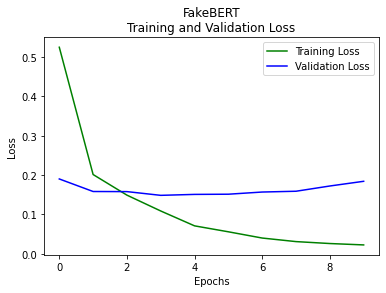

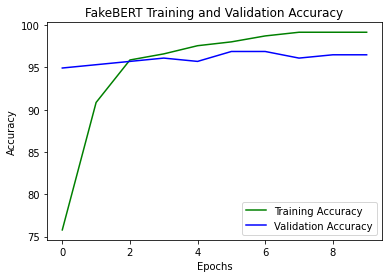

In [30]:
from source import train
from source.models.FakeBERT import initialize_model, FakeBERTCNN
from source.plot import experiment_plot

# Parameters
BATCH_SIZE = 128 # 128 in paper
N_SEQUENCES = data_tokenized['train'].shape[0]
NUM_TOKENS, EMBEDDING_SIZE = (MAX_LENGTH, 768) # The num_tokens comes from max_length in tokens
NUM_FILTERS = [128, 128, 128] # [128, 128, 128] in paper
FILTER_SIZES = [3, 4, 5] #[3,4,5] in paper
NUM_CLASSES = 2
DROPOUT = 0.2
LR = 0.001
TEST_SUBSET = True # Whether or not to get a reduced size dataset (700,200,100) in train, validation, test
EMB_LAYER = 0 # For this model, we are grabbing the embeddings not the bert output

# Get Train, Val data
train_dataloader, val_dataloader, test_dataloader = bert_data.get_data_loader(batch_size = BATCH_SIZE, test_subset = TEST_SUBSET)

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

set_seed(42)
cnn_bert = initialize_model(device, embed_dim=EMBEDDING_SIZE, filter_sizes=FILTER_SIZES,
                                       num_filters=NUM_FILTERS, num_classes=NUM_CLASSES,
                                       learning_rate=LR, dropout=DROPOUT)

# Optimizer
opt = Adam(cnn_bert.parameters(), lr=LR)


results = train.train(emb_model = bert_model, \
            model = cnn_bert,\
            loss_fn = loss_fn,\
            optimizer = opt,\
            train_dataloader = train_dataloader,\
            val_dataloader = val_dataloader,\
            epochs=10,\
            bert_layer = EMB_LAYER)

In [ ]:

plot_runner = experiment_plot(results = results,\
                              save_name = "BERT" + '-' \
                                        + 'SEQ' + str(MAX_LENGTH)\
                                        + '-LR' + str(LR)\
                                        + '-DO' + str(DROPOUT)\
                                        + '-BS' + str(BATCH_SIZE),
                              save_path = "source/experiments/figures/",\
                              append_time = True
                              )
plot_runner.plot(title_prepend = "FakeBERT",\
                 include_points = False)

### evaluate model performance on test data

In [32]:
from source import train, evaluate
test_loss, test_accuracy = evaluate.evaluate(bert_model, cnn_bert, loss_fn, test_dataloader)

print('Final Loss and Accuracy on Test: (%s,%s)' % (test_loss, test_accuracy))

  0%|          | 0/2 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.18214745074510574,94.09722222222223)


In [33]:
myrun.finish()

avg_train_loss,█▃▃▂▂▁▁▁▁▁█▃▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇██████▁▆▇▇██████
val_accuracy,▁▂▄▅▄██▅▇▇▁▂▄▅▄██▅▇▇
val_loss,█▃▃▁▁▁▂▃▅▇█▃▃▁▁▁▂▃▅▇
avg_train_loss,0.02246
epoch,9
train_acc,99.14773
val_accuracy,96.48438
val_loss,0.18411


### References

https://romanorac.github.io/machine/learning/2019/12/02/identifying-hate-speech-with-bert-and-cnn.html